# 3-3. 機械学習の基礎と展望 - 機械学習、教師あり学習（学習データ、検証データ、ホールドアウト法、交差検証法）、教師なし学習、過学習

##データセットの準備

以下では，[メディア芸術データベースのデータ](https://github.com/mediaarts-db/dataset)を利用し，4つの出版社のマンガの名前から出版社を予測する教師あり学習や，ジャンプコミックスのページ数と価格からジャンプコミックスをクラスタリングする教師なし学習を行う．
上記のリンクから「マンガ単行本」および「マンガ雑誌単号」の「.json」ファイルをダウンロードした後，このノートブックにアップロードしよう．

※「マンガ単行本」については，「1-4. 単回帰分析」，「1-4. ロジスティック回帰分析」，「1-5. 1～3次元の図表化」,「1-5. 関係性の可視化（ネットワーク構造）」，「1-7. ソートアルゴリズム」，「1-7. 探索アルゴリズム」，「2-5. データ加工」と同じデータセットを利用するため，すでにダウンロード済みの場合はそちらをアップロードしよう．

ファイルサイズがとても大きいためアップロードには時間がかかる．ファイル名が反映されたことを確認するだけでなく，ファイルアップロード時の画面の下部にあるアップロードの進捗を示す円形のバーが全て進行するまで待ってから作業しよう．（およそ30分程度）

ライブラリのインストールとデータの加工

In [ ]:
!pip install mecab-python3
!pip install unidic-lite

import re
import MeCab
import pandas as pd
import json
import random
from sklearn import svm
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics._plot.confusion_matrix import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import collections
from scipy.sparse import csr_matrix

教師あり学習に用いるデータの取得

In [ ]:
j_file=open('/content/metadata_cm-item_cm101_00001.json')
df = json.load(j_file)
comics_supervised=df['@graph']

# マンガタイトルを格納
names=[]

# マンガの出版社を格納
publishers=[]

for comic in comics_supervised:
  #  データの加工
  if('publisher' in comic.keys() and 'label' in comic.keys() and ('集英社' in comic['publisher'] or'講談社' in comic['publisher'] or '小学館' in comic['publisher'] or 'KADOKAWA' in comic['publisher'])):
    names.append(comic['label'])
    publishers.append(comic['publisher'])


教師なし学習に用いるデータの取得

In [ ]:
j_file=open('/content/metadata_cm-item_cm102_00001.json')
df = json.load(j_file)
comics_nonsupervised = df['@graph']

# 雑誌単号の名前，厚さ，ページ数のリストを格納するリスト
jumps=[]

for comic in comics_nonsupervised:
  if('label' in comic.keys() and 'ジャンプ' in comic['label']):
    if('price' in comic.keys() and 'numberOfPages' in comic.keys()):
        price=re.sub(r"\D", "", comic['price'])
        page=re.sub(r"\D", "", comic['numberOfPages'].split('p')[0])
        jumps.append([comic['label'],int(price),int(page)])

##タイトルから出版社を予測する教師あり学習



4つの出版社のマンガの名前から出版社を予測する教師あり学習を行ってみる。

In [ ]:
# 分かち書きを行うインスタンスwakatiの作成
wakati = MeCab.Tagger('-Owakati')

# 分かち書きしたタイトルを格納するリスト
wakati_names = []

for name in names:
  tmp = wakati.parse(name).strip()
  tmp = " ".join([token for token in tmp.split(" ") if token!="" and token.isnumeric()==False]) # 空文字列や数字を意味する文字列は削除する
  wakati_names.append(tmp)


In [ ]:
# 出版社ごとに作品を分ける
syueisya = []
kodansya = []
kadokawa = []
syogakukan = []

X_str=[] #特徴量
y=[] #ラベル

for name, publisher in zip(wakati_names, publishers):
  if('集英社' in publisher):
    syueisya.append(name)
  elif('講談社' in publisher):
    kodansya.append(name)
  elif('KADOKAWA' in publisher):
    kadokawa.append(name)
  elif('小学館' in publisher):
    syogakukan.append(name)

# 4つの会社の作品の中から3000個ずつ選んで今回使うデータセットとする
import random
X_str.extend(random.sample(syueisya, 3000))
y.extend([0 for i in range(3000)])

X_str.extend(random.sample(kodansya, 3000))
y.extend([1 for i in range(3000)])

X_str.extend(random.sample(kadokawa, 3000))
y.extend([2 for i in range(3000)])

X_str.extend(random.sample(syogakukan, 3000))
y.extend([3 for i in range(3000)])

vec_tfidf = TfidfVectorizer()
X=vec_tfidf.fit_transform(X_str) #文字列を特徴量化

# テストデータと学習データに分ける
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

###学習データ、検証データ

####ホールドアウト法

In [ ]:
model=svm.SVC()
model.fit(X_train,y_train)
pred=model.predict(X_test)
print('正答率：',accuracy_score(y_test,pred))

cm=confusion_matrix(y_test,pred)
print(cm)

正答率： 0.6256666666666667
[[456 158  69  97]
 [ 81 505  90  99]
 [ 52  94 477  70]
 [ 70 170  73 439]]


####交差検証法
データ全体をn分割して，そのうちの一つをテストデータ・残りのn-1個を学習データとしてテストデータのAccuracyを見る手法．
以下のコードは実行に5分ほどかかるため注意．

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
cv = KFold(n_splits=5, random_state=0, shuffle=True)#5個に分割
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print(scores)

[0.61125    0.60875    0.615      0.62333333 0.61458333]


平均値は次のようになる．

In [ ]:
np.mean(scores)

0.6145833333333333

##厚さによるコミックス分類の教師なし学習

ジャンプコミックスのページ数と厚さからジャンプコミックスをクラスタリングする教師なし学習を行う。

In [ ]:
# jumpsの要素は[ジャンプコミックスの名前，価格，ページ数]というリスト

jdata=[]
for i in range (len(jumps)):
  jdata.append([jumps[i][2],jumps[i][1]])

In [ ]:
# 各要素ごとにどのジャンルのマンガなのか（＝どのクラスタにあるべきなのか）という正解ラベルを作っていく
y_true = []

# マンガジャンルとインデックス（数字）を紐づけるためのリスト
cluster = []
for jump in jumps:
  tmp=jump[0].split(' ')[0]
  flag=1
  for i in range(len(cluster)):
    if cluster[i]==tmp:
      flag=0
      y_true.append(i)
      break
  if flag==1:
    cluster.append(tmp)
    y_true.append(len(cluster))

# クラスターがいくつあるのか確認する
# 本来はクラスタリングの際には正解のクラスタ数はわからないことが多いため，適切なクラスタ数を考えながら繰り返しクラスタリングを行う

collections.Counter(y_true)

Counter({1: 38,
         2: 11,
         3: 1465,
         4: 52,
         5: 17,
         6: 1,
         7: 26,
         8: 1,
         9: 5,
         10: 4,
         11: 2,
         12: 88,
         13: 34,
         14: 3,
         15: 1,
         16: 22,
         17: 220,
         18: 5,
         19: 1,
         20: 1,
         21: 797,
         22: 8,
         23: 2,
         24: 16,
         25: 27,
         26: 66,
         27: 8,
         28: 1,
         29: 3,
         30: 2,
         31: 1,
         32: 1,
         33: 9,
         34: 87,
         35: 20,
         36: 72,
         37: 173,
         38: 40,
         39: 1,
         40: 5,
         41: 16,
         42: 21,
         43: 15,
         0: 8,
         44: 17,
         45: 1,
         46: 43,
         47: 112,
         48: 1,
         49: 1,
         50: 1,
         51: 4,
         52: 1,
         53: 4,
         54: 1,
         55: 5,
         56: 1})

In [ ]:
# クラスタ数を決める
num_c=9

# 正規化
jdata_ss=StandardScaler().fit_transform(jdata)


model = KMeans(n_clusters=num_c)#K-平均法

# 重心計算
kmeans=model.fit(jdata_ss)

# 各データの所属クラスタを予測したもの
y_pred=kmeans.labels_


#プロット
x1 = [d[0] for d in jdata_ss]
x2 = [d[1] for d in jdata_ss]



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


予測したクラスタによる分布図が以下．

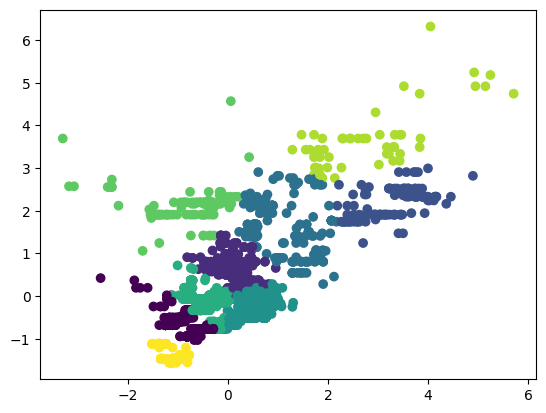

In [ ]:
#横軸がページ，縦軸が厚さになっている
plt.scatter(x1,x2,c=y_pred)

正解のクラスタの分布図が以下．

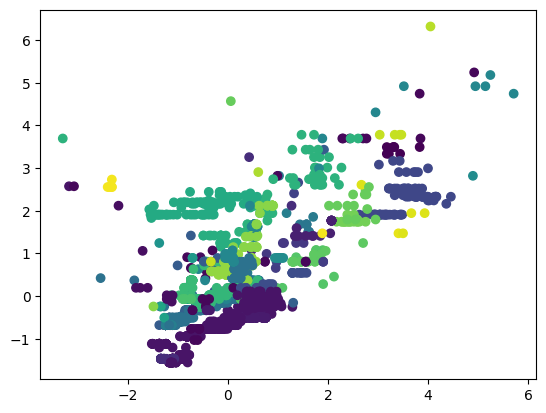

In [ ]:
plt.scatter(x1, x2, c=y_true)

##過学習

先ほどの教師あり学習のデータを改変して意図的に過学習を起こしてみる。
以下では，学習データが偏ってしまっているために汎化性能が上がらない例を見ていく．

In [ ]:
# 出版社ごとに作品を分ける
syueisya = []
kodansya = []
kadokawa = []
syogakukan = []

X_str=[] #特徴量
y=[] #ラベル

for name, publisher in zip(wakati_names, publishers):
  if('集英社' in publisher):
    syueisya.append(name)
  elif('講談社' in publisher):
    kodansya.append(name)
  elif('KADOKAWA' in publisher):
    kadokawa.append(name)
  elif('小学館' in publisher):
    syogakukan.append(name)

# 集英社の作品のみ5000個，残り3社の作品は1000個ずつ選んで今回使う学習データセットとする
# テストデータセットは4社とも100個ずつバランスよく選ぶ

import random
syueisya = random.sample(syueisya, 5100)
X_str.extend(syueisya)

kodansya = random.sample(kodansya, 1100)
X_str.extend(kodansya)

kadokawa = random.sample(kadokawa, 1100)
X_str.extend(kadokawa)

syogakukan = random.sample(syogakukan, 1100)
X_str.extend(syogakukan)

vec_tfidf = TfidfVectorizer()
X=vec_tfidf.fit(X_str) #文字列を特徴量化

# テストデータと学習データに分ける
X_train = []
X_test = []
y_train = []
y_test = []

for i, publisher in enumerate([syueisya, kodansya, kadokawa, syogakukan]):
    X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(publisher, [i for j in range(len(publisher))], test_size=100, random_state=1)
    print(type(vec_tfidf.transform(X_train_sub)[0]))
    X_train.extend(vec_tfidf.transform(X_train_sub).toarray())
    X_test.extend(vec_tfidf.transform(X_test_sub).toarray())
    y_train.extend(y_train_sub)
    y_test.extend(y_test_sub)

# この後の学習を高速化するためにスパースマトリクスに戻す
X_train = csr_matrix(X_train)
X_test = csr_matrix(X_test)

<class 'scipy.sparse._csr.csr_matrix'>
<class 'scipy.sparse._csr.csr_matrix'>
<class 'scipy.sparse._csr.csr_matrix'>
<class 'scipy.sparse._csr.csr_matrix'>


In [ ]:
model=svm.SVC()
model.fit(X_train,y_train)

SVC()

In [ ]:
pred=model.predict(X_test)
print('正答率：',accuracy_score(y_test,pred))
cm=confusion_matrix(y_test,pred)
print(cm)

正答率： 0.4175
[[97  2  0  1]
 [71 27  1  1]
 [81  0 18  1]
 [73  1  1 25]]


集英社のデータばかりのデータセットで学習したために，そのバランスに過学習してしまい，性能の良くないモデルになってしまっていることがわかる．